In [46]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal, norm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Task 1

In [47]:
class LDA():
    """Implementation of LDA classifier."""
    def __init__(self):
        self.classes = None
        self.means = None
        self.shared_cov = None
        self.priors = None
        
    def fit(self, X, y):
        # fields setup before calculation
        self.classes = np.unique(y)
        n_observations, n_features = X.shape
        self.means = np.zeros((2, n_features))
        self.shared_cov = np.zeros((n_features, n_features))
        self.priors = np.zeros(2)

        for i, c in enumerate(self.classes):
            # for each class:
            # - take observations labeled as processed class
            X_c = X[y == c]
            # - calculate means
            self.means[i, :] = X_c.mean(axis=0)
            # - calculate prior
            self.priors[i] = X_c.shape[0] / float(X.shape[0])
            # - calculate empirical covariance (without normalization)
            self.shared_cov += ((X_c - self.means[i]).T @ (X_c - self.means[i]))

        # calculate within class covariance
        self.shared_cov /= n_observations - len(self.classes)

        
    def predict_proba(self, X_test):
        # variables setup
        n_samples = X_test.shape[0]
        probabilities = np.zeros((n_samples, 2))

        for i, c in enumerate(self.classes):
            # for each class calculate pdf
            likelihood = multivariate_normal(mean=self.means[i], cov=self.shared_cov).pdf(X_test)
            probabilities[:,i] = likelihood * self.priors[i]
        return probabilities / np.sum(probabilities, axis=1, keepdims=True)
        
    def predict(self, X_test):
        return np.argmax(self.predict_proba(X_test), axis=1)
    
    def get_params(self):
        return [self.means, self.shared_cov, self.priors]


In [48]:
class QDA():
    """Implementation of QDA classifier."""
    def __init__(self):
        self.classes = None
        self.means = None
        self.covs = None
        self.priors = None
        
    def fit(self, X, y):
        # fields setup before calculation
        self.classes = np.unique(y)
        n_observations, n_features = X.shape
        self.means = np.zeros((len(self.classes), n_features))
        self.covs = [np.zeros((n_features, n_features)) for i in range(len(self.classes))]
        self.priors = np.zeros(2)
        
        for i, c in enumerate(self.classes):
            # for each class:
            # - take observations labeled as processed class
            X_c = X[y == c]
            # - calculate means
            self.means[i, :] = X_c.mean(axis=0)
            # - calculate covariance
            self.covs[i] = np.cov(X_c.T)
            # - calculate priors
            self.priors[i] = X_c.shape[0] / float(X.shape[0])
        
    def predict_proba(self, X_test):
        # variables setup
        n_samples = X_test.shape[0]
        probabilities = np.zeros((n_samples, 2))

        for i, c in enumerate(self.classes):
            # for each class calculate pdf
            likelihood = multivariate_normal(mean=self.means[i], cov=self.covs[i], allow_singular=True).pdf(X_test)
            probabilities[:,i] = likelihood * self.priors[i]

        return probabilities / np.sum(probabilities, axis=1, keepdims=True)
        
    def predict(self, X_test):
        return np.argmax(self.predict_proba(X_test), axis=1)
    
    def get_params(self):
        return [self.means, self.covs, self.priors]


In [49]:
class NB():
    """Implementation of Naive Bayes classifier."""
    def __init__(self):
        self.classes = None
        self.means = None
        self.stds = None
        self.priors = None
        
    def fit(self, X, y):
        # fitting parameters using list comprahension
        # it could be also used in LDA and QDA implementation
        self.classes = np.unique(y)
        self.means = np.array([X[y == c].mean(axis=0) for c in self.classes])
        self.stds = np.array([X[y == c].std(axis=0) for c in self.classes])
        self.priors = np.array([np.mean(y == c) for c in self.classes])
        
    def predict_proba(self, X_test):
        # variables setup
        n_samples = X_test.shape[0]
        probabilities = np.zeros((n_samples, 2))

        for i, c in enumerate(self.classes):
            # for each class calculate pdf
            likelihood = norm.pdf(X_test, loc=self.means[i], scale=self.stds[i])
            probabilities[:,i] = likelihood.prod(axis=1) * self.priors[i]

        return probabilities / np.sum(probabilities, axis=1, keepdims=True)
    
    def predict(self, X_test):
        probs = self.predict_proba(X_test)
        return self.classes[np.argmax(probs, axis=1)]
    
    def get_params(self):
        return [self.means, self.stds, self.priors]


# Task 2


In [50]:
def scheme1_data(a, n=1000):
    p = 2
    y = np.random.binomial(1, 0.5, size=n)
    one_length = y.sum()
    zero_length = n - one_length

    X_0 = np.random.normal(0, 1, size=(zero_length, p))
    X_1 = np.random.normal(a, 1, size=(one_length, p))

    X = np.vstack((X_0, X_1))
    y = np.hstack((np.zeros(zero_length), np.ones(one_length)))

    return X, y

def scheme2_data(a, rho, n=1000):
    p = 2
    y = np.random.binomial(1, 0.5, size=n)
    one_length = y.sum()
    zero_length = n - one_length

    m_0 = np.zeros(p) 
    cov_0 = np.array([[1, rho] ,[rho, 1]])
    X_0 = np.random.multivariate_normal(m_0, cov_0, size=zero_length)

    m_1 = np.ones(p) * a
    cov_1 = np.array([[1, -rho], [-rho, 1]])
    X_1 = np.random.multivariate_normal(m_1, cov_1, size=one_length)

    X = np.vstack((X_0, X_1))
    y = np.hstack((np.zeros(zero_length), np.ones(one_length)))

    return X, y

def score(X, y):
    return np.sum(X==y)/len(X)

def experiment(means, rhos, test_sizes, sheme: int = 1, data = None):

    random_states = [11 * i for i in range(10)]

    lda_accuracy = []
    qda_accuracy = []
    nb_accuracy = []

    for i in range(len(means)):
        a = means[i]
        rho = rhos[i]
        data = scheme1_data(a=a) if sheme == 1 else scheme2_data(a=a, rho=rho) 
        for s in test_sizes:
            data_extended = [train_test_split(data[0], data[1], test_size=s, random_state=r) for r in random_states]
            for batch in data_extended:
                X_train, X_test, y_train, y_test = batch

                lda = LDA()
                lda.fit(X_train, y_train)
                X_pred = lda.predict(X_test=X_test)
                lda_acc = score(X=X_pred, y=y_test)
                lda_accuracy.append(lda_acc)

                qda = QDA()
                qda.fit(X_train, y_train)
                X_pred = qda.predict(X_test=X_test)
                qda_acc = score(X=X_pred, y=y_test)
                qda_accuracy.append(qda_acc)

                nb = NB()
                nb.fit(X_train, y_train)
                X_pred = nb.predict(X_test=X_test)
                nb_acc = score(X=X_pred, y=y_test)
                nb_accuracy.append(nb_acc)

    lda_accuracy = np.array(lda_accuracy).reshape(len(means), len(test_sizes) * len(random_states))
    qda_accuracy = np.array(qda_accuracy).reshape(len(means), len(test_sizes) * len(random_states))
    nb_accuracy = np.array(nb_accuracy).reshape(len(means), len(test_sizes) * len(random_states))
    return lda_accuracy, qda_accuracy, nb_accuracy

def experiment_real(test_sizes, data):

    random_states = [11 * i for i in range(10)]

    lda_accuracy = []
    qda_accuracy = []
    nb_accuracy = []

    for s in test_sizes:
        data_extended = [train_test_split(data[0], data[1], test_size=s, random_state=r) for r in random_states]
        for batch in data_extended:
            X_train, X_test, y_train, y_test = batch

            lda = LDA()
            lda.fit(X_train, y_train)
            X_pred = lda.predict(X_test=X_test)
            lda_acc = score(X=X_pred, y=y_test)
            lda_accuracy.append(lda_acc)

            qda = QDA()
            qda.fit(X_train, y_train)
            X_pred = qda.predict(X_test=X_test)
            qda_acc = score(X=X_pred, y=y_test)
            qda_accuracy.append(qda_acc)

            nb = NB()
            nb.fit(X_train, y_train)
            X_pred = nb.predict(X_test=X_test)
            nb_acc = score(X=X_pred, y=y_test)
            nb_accuracy.append(nb_acc)

    return lda_accuracy, qda_accuracy, nb_accuracy        

### 1

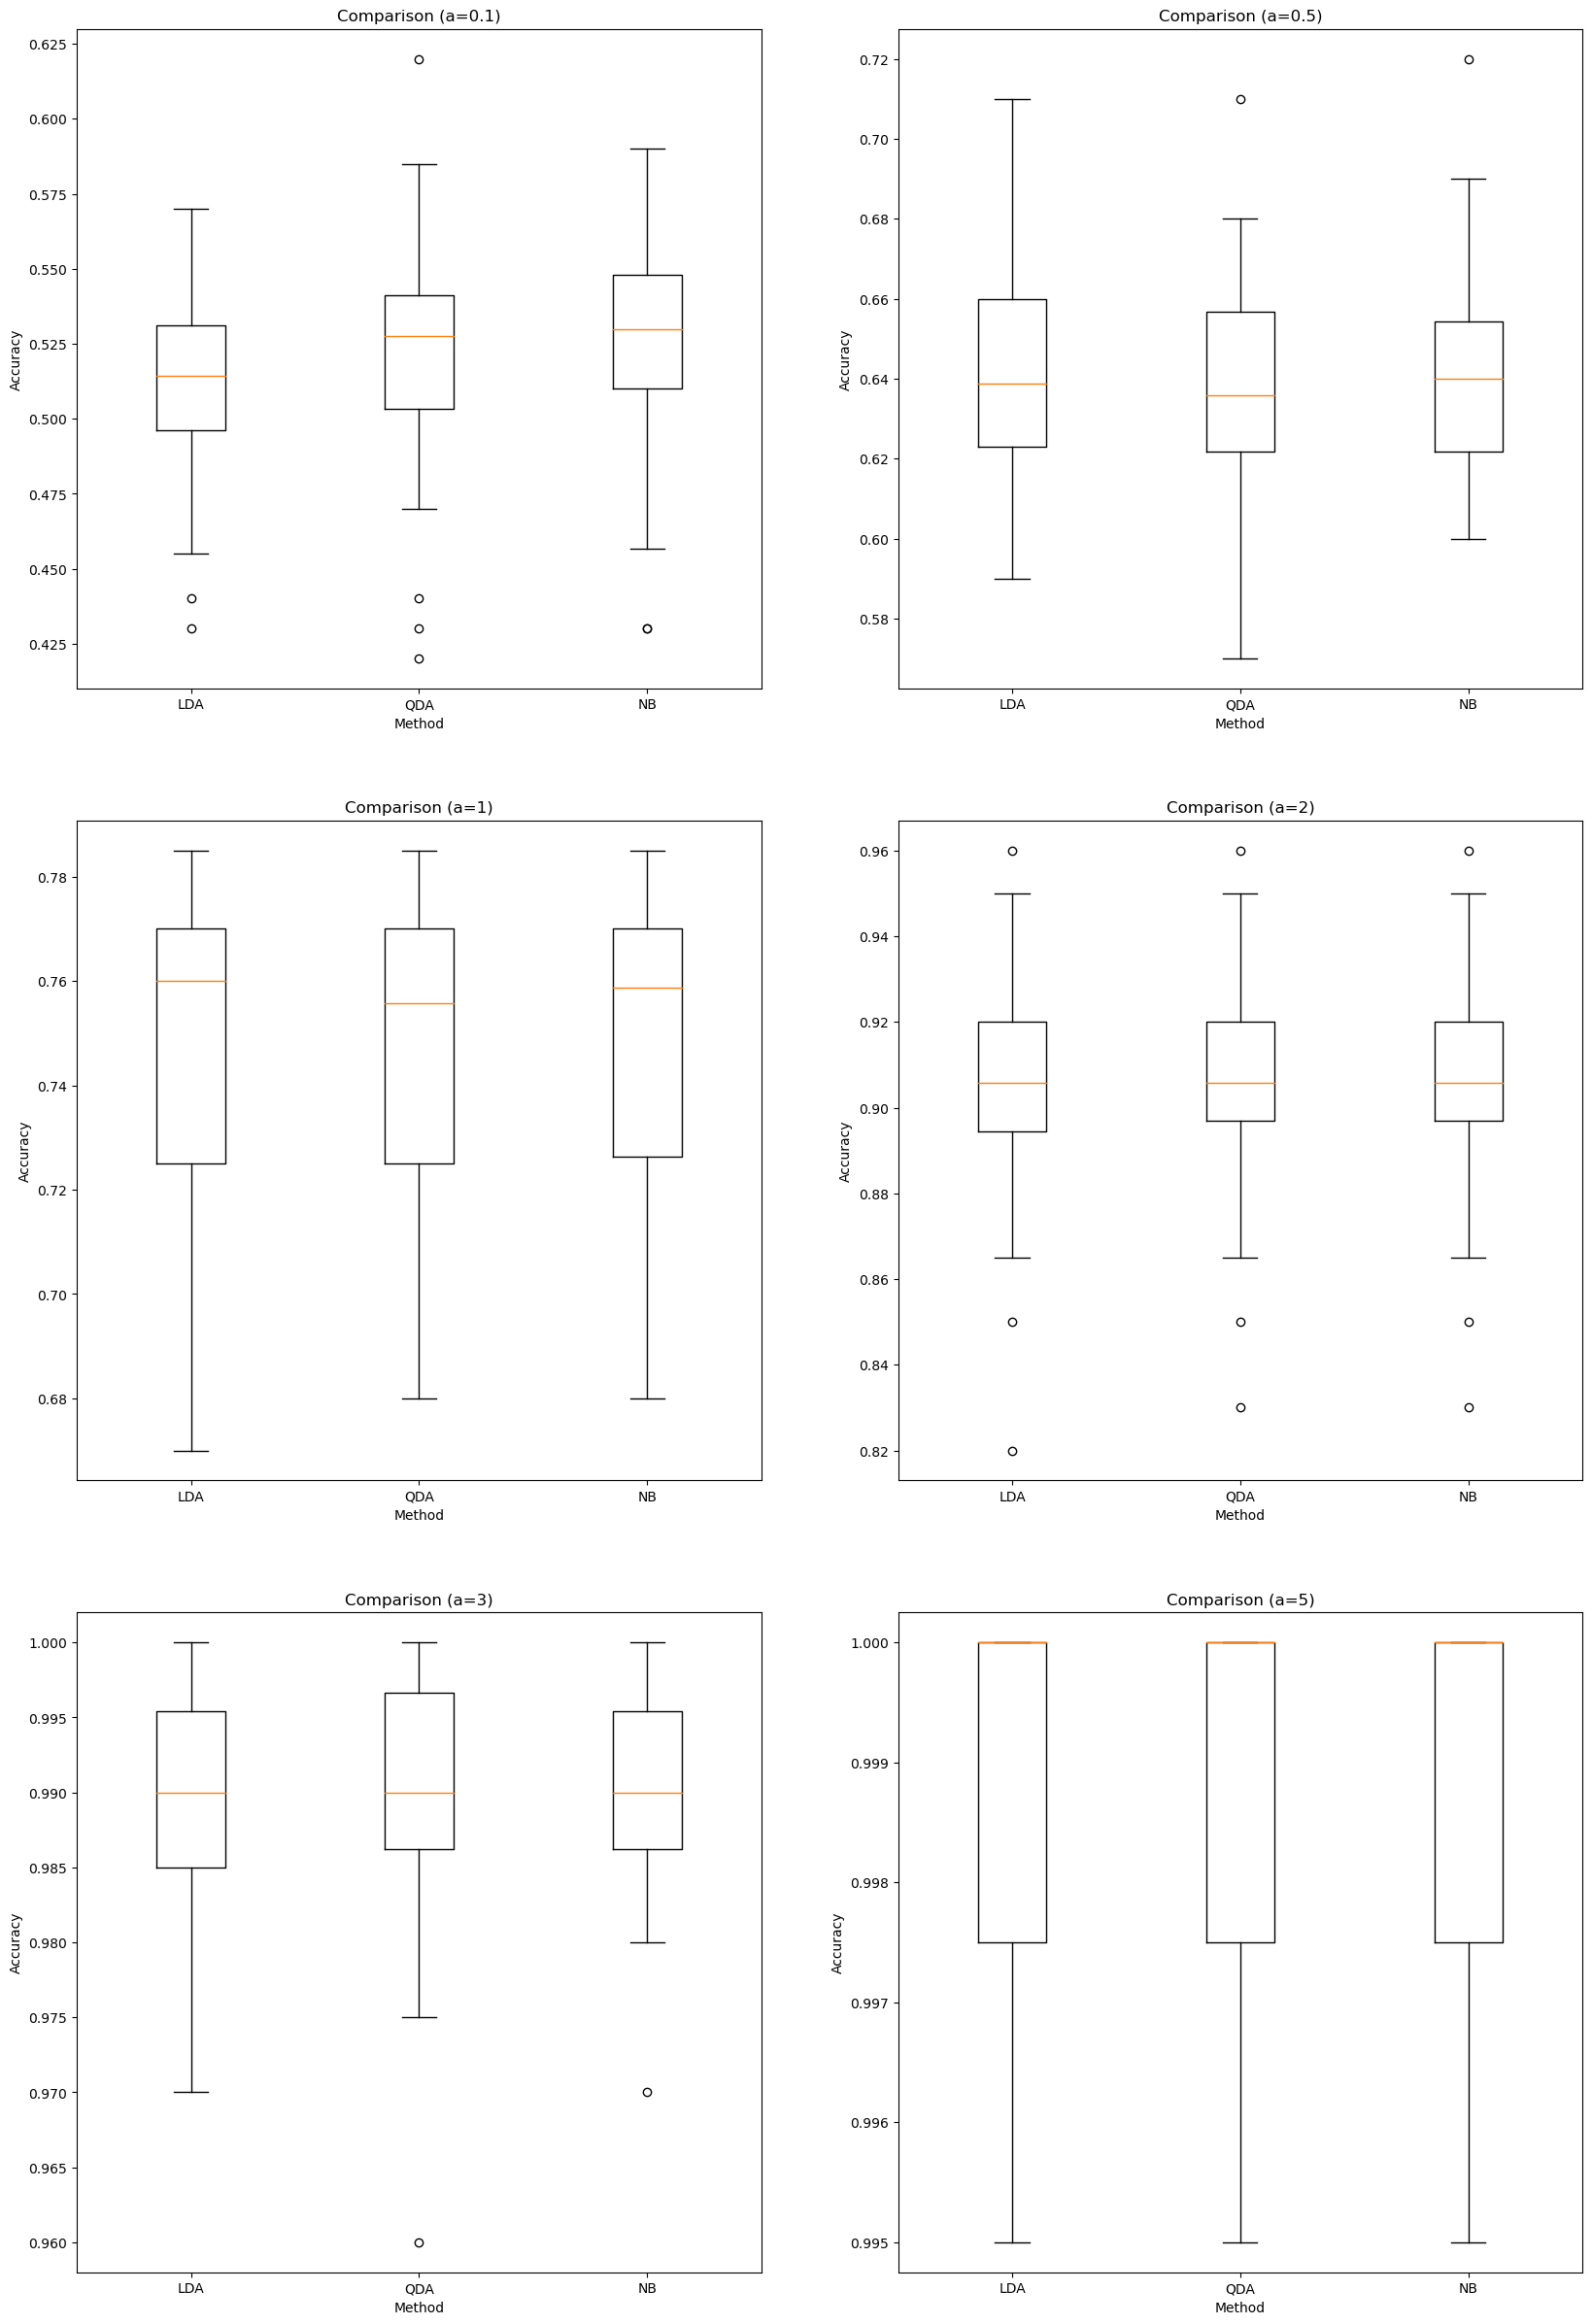

In [51]:
means = [0.1, 0.5, 1, 2, 3, 5]
rhos = [0.5 for i in range(6)]
test_sizes = [0.4, 0.3, 0.2, 0.1]

lda_accuracy, qda_accuracy, nb_accuracy = experiment(means, rhos, test_sizes, sheme=1)

comparison = []
fig, axs = plt.subplots(3, 2, figsize=(20, 30))
for i, a in enumerate(means):
    comparison.append([lda_accuracy[i], qda_accuracy[i], nb_accuracy[i]])
    axs[i//2, i%2].boxplot(comparison[-1], labels=["LDA", "QDA", "NB"])
    axs[i//2, i%2].set_title(f'Comparison (a={a})')
    axs[i//2, i%2].set_ylabel('Accuracy')
    axs[i//2, i%2].set_xlabel('Method')


plt.savefig('output\\BayesianSimulatedData1.pdf')

### 2

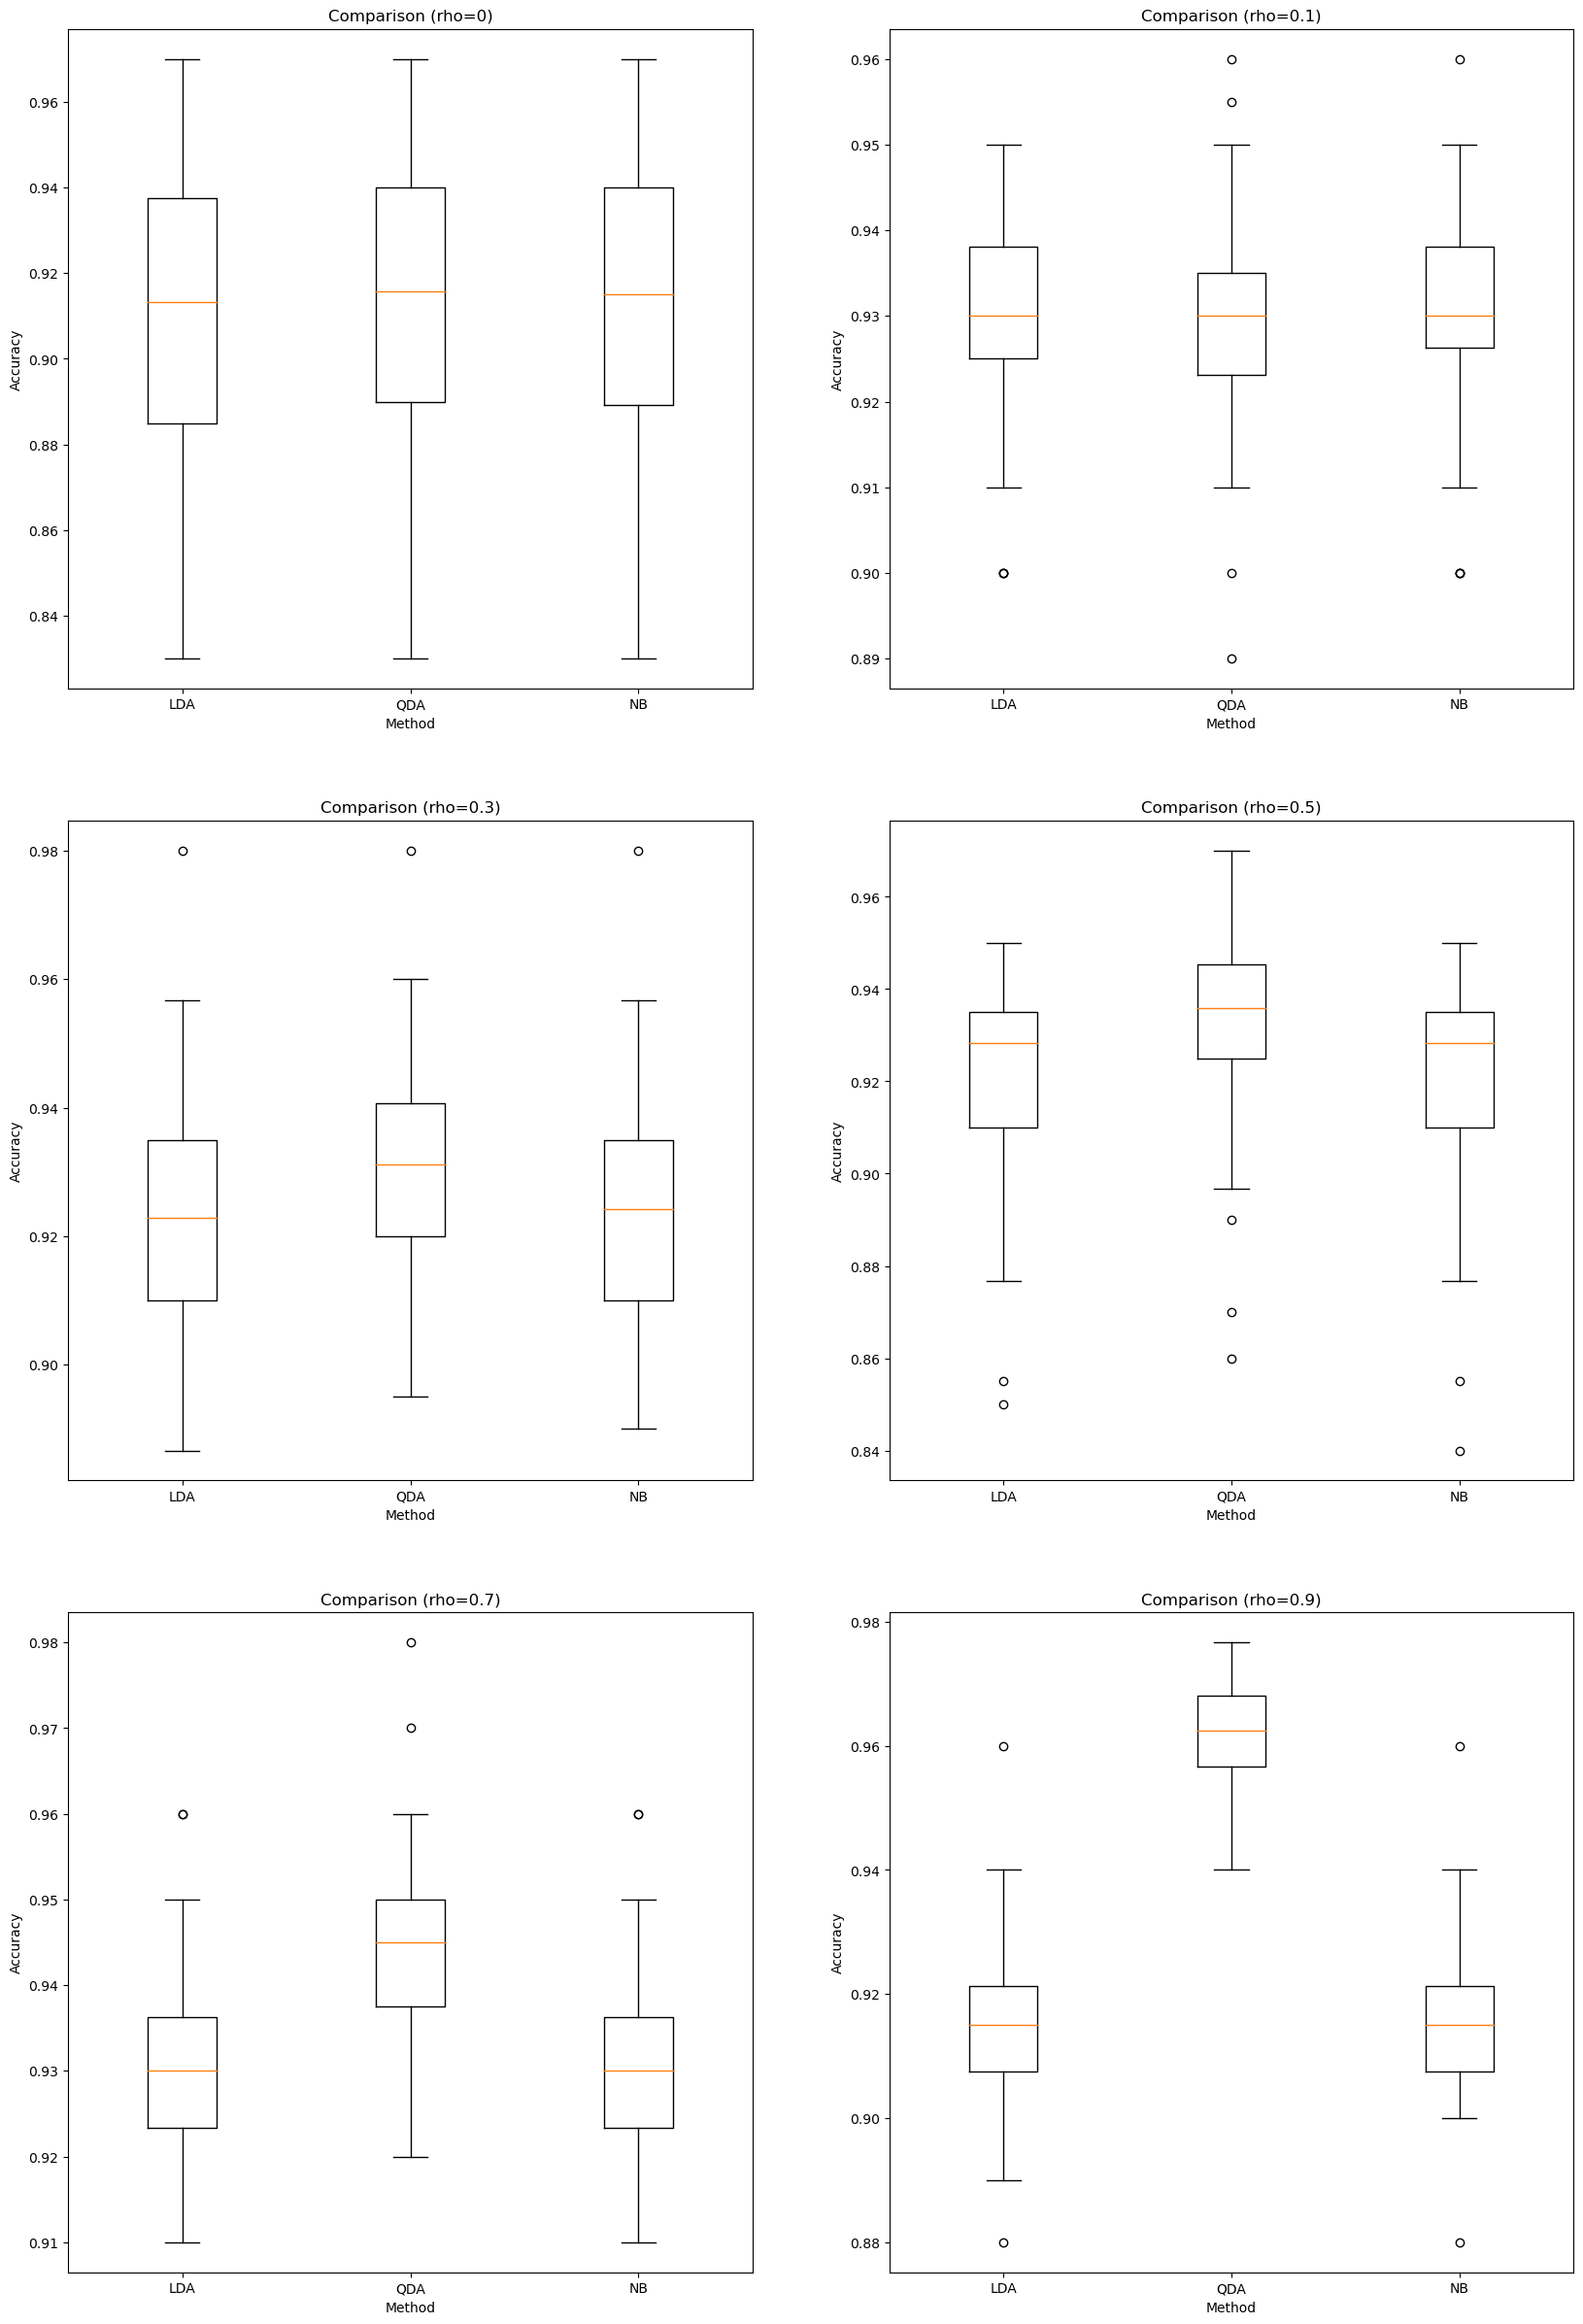

In [52]:
means = [2 for i in range(6)]
rhos = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
test_sizes = [0.4, 0.3, 0.2, 0.1]

lda_accuracy, qda_accuracy, nb_accuracy = experiment(means, rhos, test_sizes, sheme=2)

comparison = []
fig, axs = plt.subplots(3, 2, figsize=(20, 30))
for i, rho in enumerate(rhos):
    comparison.append([lda_accuracy[i], qda_accuracy[i], nb_accuracy[i]])
    axs[i//2, i%2].boxplot(comparison[-1], labels=["LDA", "QDA", "NB"])
    axs[i//2, i%2].set_title(f'Comparison (rho={rho})')
    axs[i//2, i%2].set_ylabel('Accuracy')
    axs[i//2, i%2].set_xlabel('Method')


plt.savefig('output\\BayesianSimulatedData2.pdf')

### 3

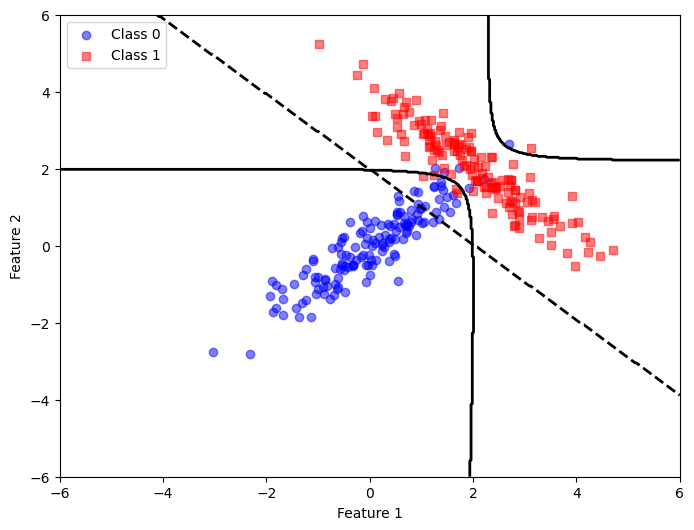

In [61]:
X, y = scheme2_data(2, 0.9, 300)

lda = LDA()
qda = QDA()

lda.fit(X, y)
qda.fit(X, y)

# Create a mesh grid to plot the decision boundaries
xx, yy = np.meshgrid(np.linspace(-6, 6, 500), np.linspace(-6, 6, 500))
line_lda = lda.predict(np.c_[xx.ravel(), yy.ravel()])
line_lda = line_lda.reshape(xx.shape)
line_qda = qda.predict(np.c_[xx.ravel(), yy.ravel()])
line_qda = line_qda.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(20,30))
ax.scatter(X[y == 0, 0], X[y == 0, 1], c='b', marker='o', label='Class 0', alpha=0.5)
ax.scatter(X[y == 1, 0], X[y == 1, 1], c='r', marker='s', label='Class 1', alpha=0.5)
ax.contour(xx, yy, line_lda, levels=[0], linewidths=2, colors='k', linestyles='--')
ax.contour(xx, yy, line_qda, levels=[0], linewidths=2, colors='k', linestyles='-')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend(loc='upper left')
fig.savefig('output\\BayesianSimulatedData3.pdf')
plt.show()

# Task 3

In [54]:
test_sizes = [0.4, 0.3, 0.2, 0.1]
results = {}

### Divorce Predictors data set

In [55]:
data1 = pd.read_csv('data\\divorce.csv', sep=";")
X = data1.iloc[:,:-1].values
y = data1.iloc[:,-1].values

results['Divorce'] = experiment_real(test_sizes, data=(X, y))



C:\Users\Testy\AppData\Local\Temp\ipykernel_8528\2023095046.py:41: RuntimeWarning: invalid value encountered in divide
  return probabilities / np.sum(probabilities, axis=1, keepdims=True)
C:\Users\Testy\AppData\Local\Temp\ipykernel_8528\4195340839.py:38: RuntimeWarning: invalid value encountered in divide
  return probabilities / np.sum(probabilities, axis=1, keepdims=True)
c:\Users\Testy\anaconda3\envs\aml\lib\site-packages\scipy\stats\_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\Testy\anaconda3\envs\aml\lib\site-packages\scipy\stats\_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


### Haberman data set

In [56]:
data2 = pd.read_csv('data\\haberman.csv', sep=";")
X = data2.iloc[:,:-1].values
y = data2.iloc[:,-1].values

results['Haberman'] = experiment_real(test_sizes, data=(X, y))

### Sepsis Survival data set

In [57]:
data3 = pd.read_csv('data\\sepsis_survival_primary_cohort.csv', sep=";")
X = data3.iloc[:,:-1].values
y = data3.iloc[:,-1].values

results['Sepsis Survival'] = experiment_real(test_sizes, data=(X, y))

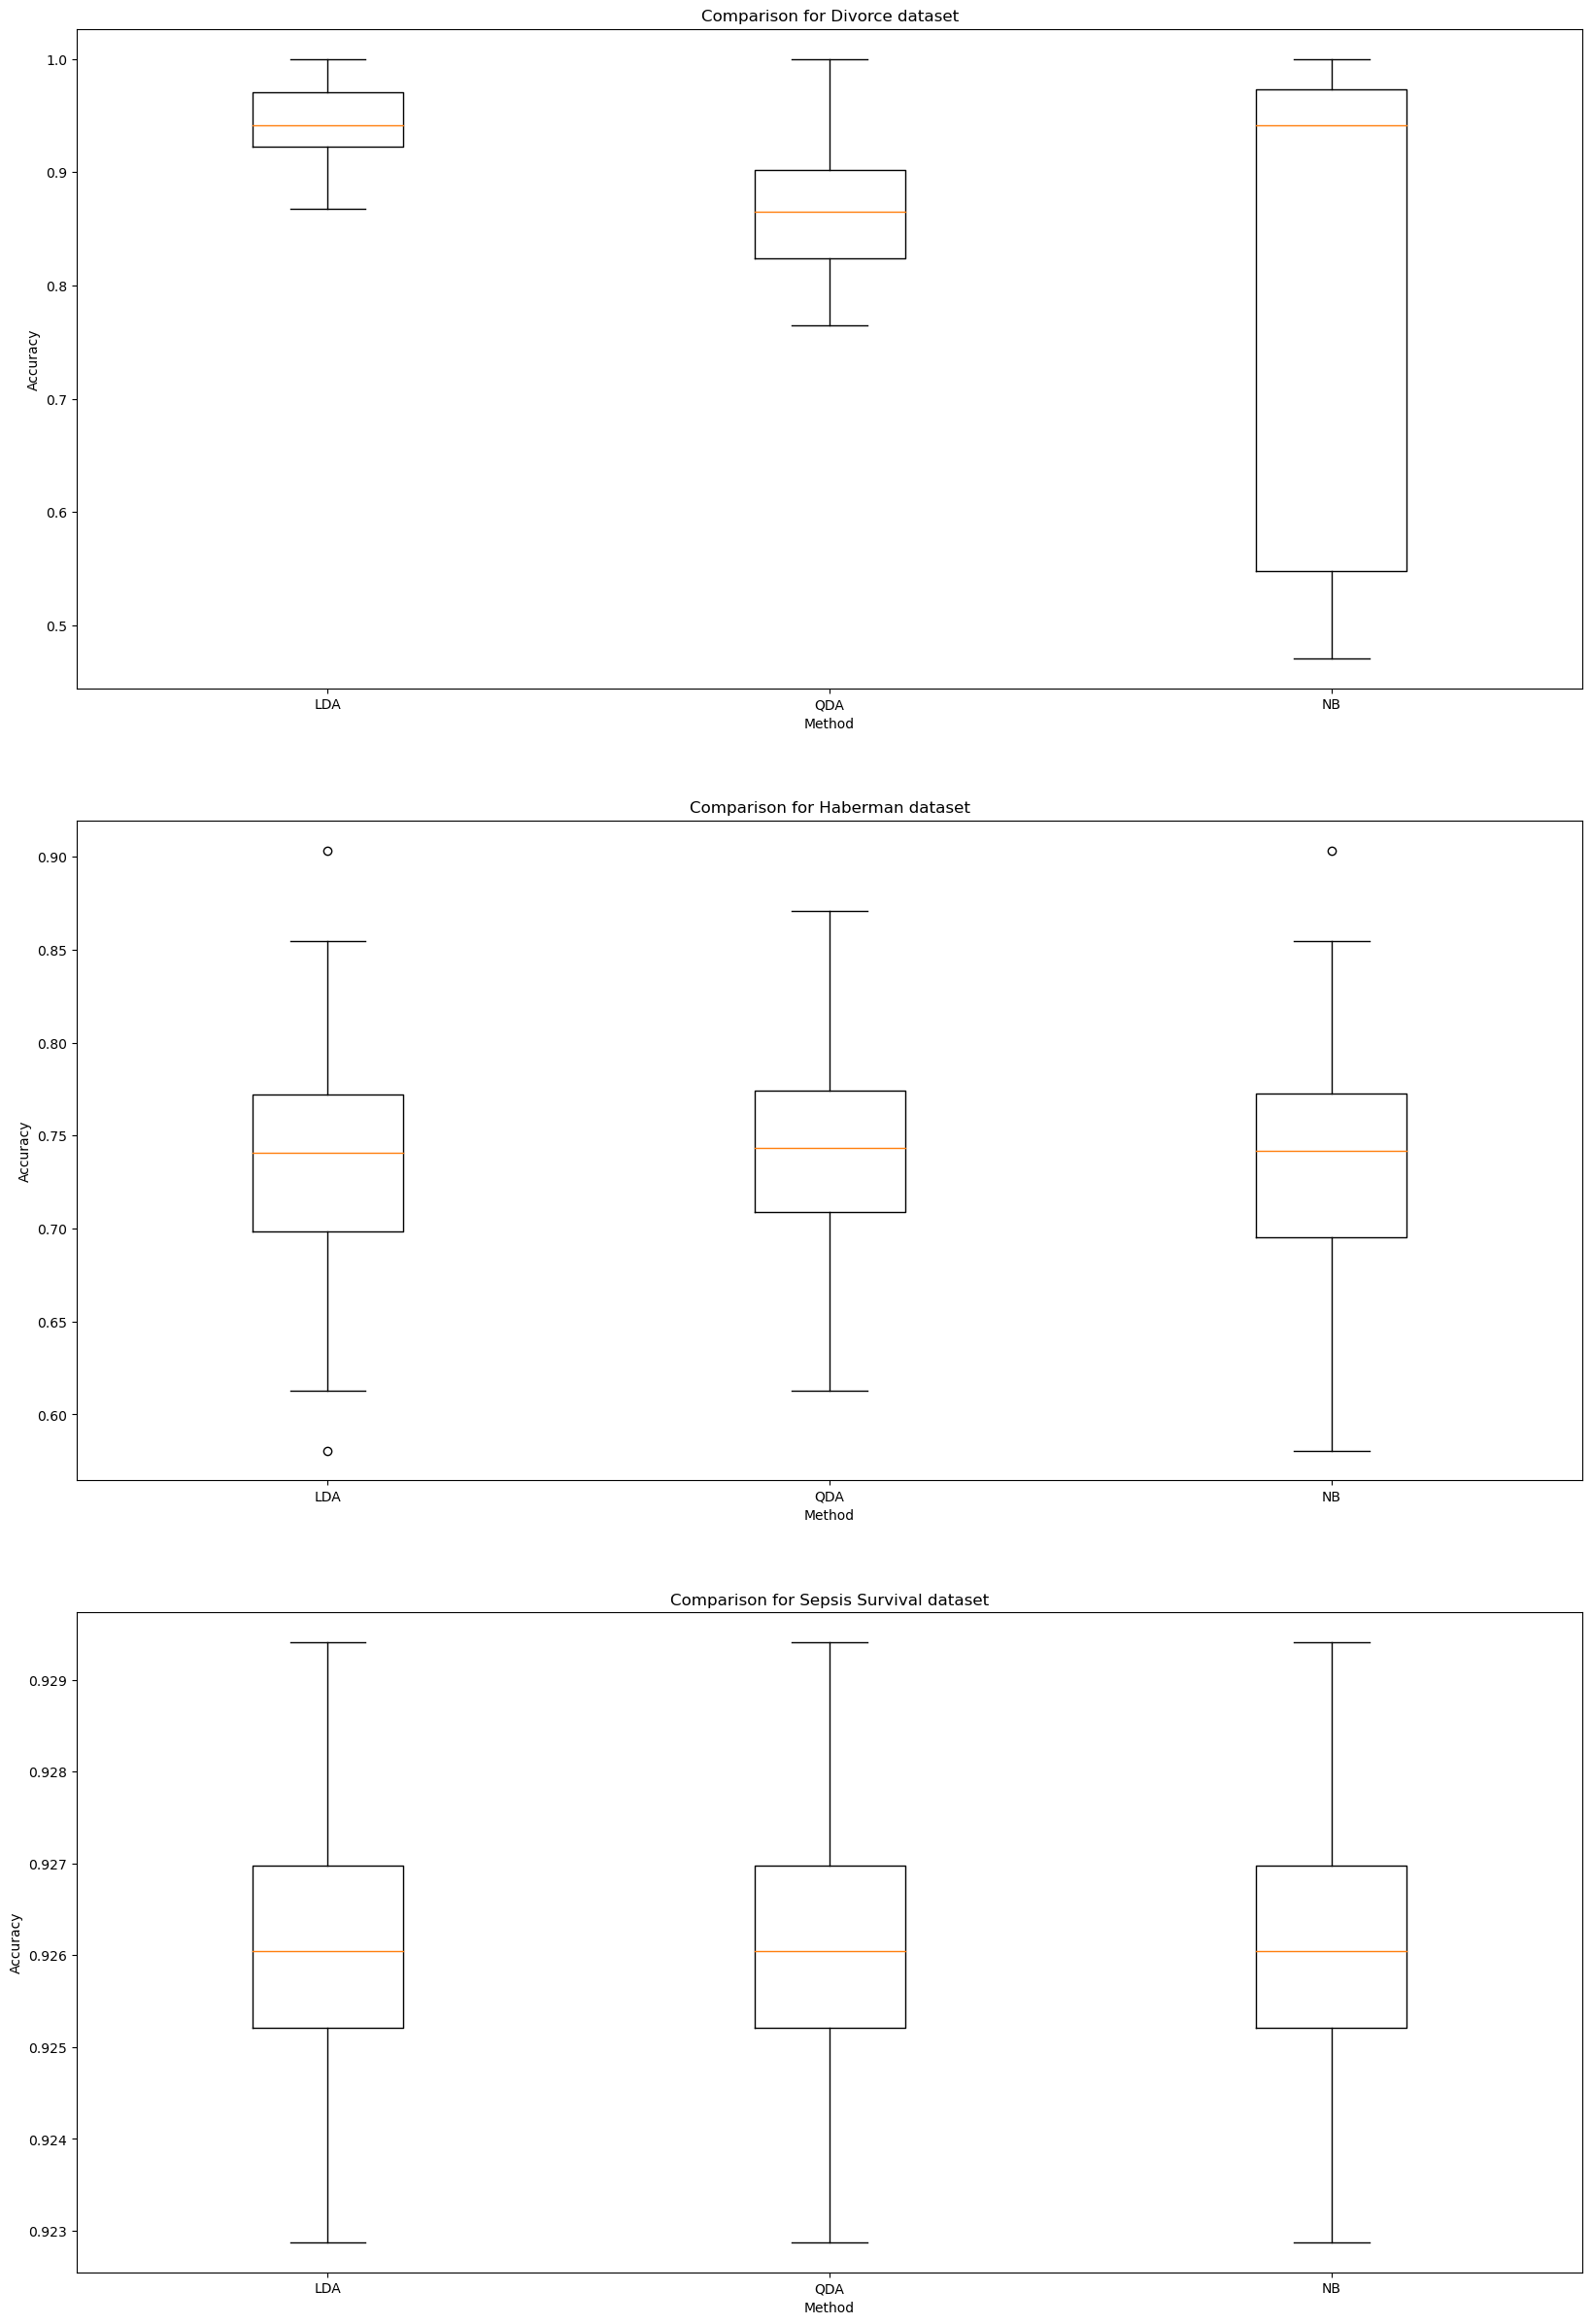

In [58]:

fig, axs = plt.subplots(3, 1, figsize=(20, 30))
for i, j in enumerate(results.items()):
    k, v = j
    axs[i].boxplot(v, labels=["LDA", "QDA", "NB"])
    axs[i].set_title(f'Comparison for {k} dataset')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_xlabel('Method')


plt.savefig('output\\BayesianReal.pdf')